# S6207 4: auto-encoder

Basic Tasks:

• Download Titanic dataset from the blackboard, preprocess (one-hot + scale)

• Load with PyTorch DataLoader (80/20 split).

• Train feedforward AE (latent dim=8, MSE loss, >50 epochs).

• Measure the error.

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [13]:
# Load the Titanic dataset
df = pd.read_csv('data.txt')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nData types:")
print(df.dtypes)


Dataset shape: (891, 12)

First few rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0     

In [14]:
# Preprocessing: Handle missing values and prepare for one-hot encoding
df_processed = df.copy()

# Fill missing Age with median
df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)

# Fill missing Fare with median
df_processed['Fare'].fillna(df_processed['Fare'].median(), inplace=True)

# Fill missing Embarked with mode
df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)

# Fill missing Cabin with 'Unknown'
df_processed['Cabin'].fillna('Unknown', inplace=True)

# Extract features for autoencoder (we'll use all features except PassengerId, Name, Ticket)
# These are identifiers and not useful for reconstruction
features_to_encode = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

# Create a subset dataframe for encoding
df_features = df_processed[features_to_encode].copy()

# One-hot encode categorical variables
categorical_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked']
df_encoded = pd.get_dummies(df_features, columns=categorical_cols, drop_first=False)

print(f"Shape after one-hot encoding: {df_encoded.shape}")
print(f"\nColumn names: {list(df_encoded.columns)}")


Shape after one-hot encoding: (891, 160)

Column names: ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_A10', 'Cabin_A14', 'Cabin_A16', 'Cabin_A19', 'Cabin_A20', 'Cabin_A23', 'Cabin_A24', 'Cabin_A26', 'Cabin_A31', 'Cabin_A32', 'Cabin_A34', 'Cabin_A36', 'Cabin_A5', 'Cabin_A6', 'Cabin_A7', 'Cabin_B101', 'Cabin_B102', 'Cabin_B18', 'Cabin_B19', 'Cabin_B20', 'Cabin_B22', 'Cabin_B28', 'Cabin_B3', 'Cabin_B30', 'Cabin_B35', 'Cabin_B37', 'Cabin_B38', 'Cabin_B39', 'Cabin_B4', 'Cabin_B41', 'Cabin_B42', 'Cabin_B49', 'Cabin_B5', 'Cabin_B50', 'Cabin_B51 B53 B55', 'Cabin_B57 B59 B63 B66', 'Cabin_B58 B60', 'Cabin_B69', 'Cabin_B71', 'Cabin_B73', 'Cabin_B77', 'Cabin_B78', 'Cabin_B79', 'Cabin_B80', 'Cabin_B82 B84', 'Cabin_B86', 'Cabin_B94', 'Cabin_B96 B98', 'Cabin_C101', 'Cabin_C103', 'Cabin_C104', 'Cabin_C106', 'Cabin_C110', 'Cabin_C111', 'Cabin_C118', 'Cabin_C123', 'Cabin_C124', 'Cabin_C125', 'Cabin_C126', 'Cabin_C128', 'Cabin_C148', 'Cabin_C2', 'C

In [15]:
# Scale the features using StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_encoded)
data_scaled = pd.DataFrame(data_scaled, columns=df_encoded.columns)

print(f"Scaled data shape: {data_scaled.shape}")
print(f"\nScaled data statistics:")
print(data_scaled.describe())
print(f"\nFirst few rows of scaled data:")
print(data_scaled.head())


Scaled data shape: (891, 160)

Scaled data statistics:
                Age         SibSp         Parch          Fare      Pclass_1  \
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02   
mean   2.272780e-16  4.386066e-17  5.382900e-17  3.987333e-18 -7.575933e-17   
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00   
min   -2.224156e+00 -4.745452e-01 -4.736736e-01 -6.484217e-01 -5.656854e-01   
25%   -5.657365e-01 -4.745452e-01 -4.736736e-01 -4.891482e-01 -5.656854e-01   
50%   -1.046374e-01 -4.745452e-01 -4.736736e-01 -3.573909e-01 -5.656854e-01   
75%    4.333115e-01  4.327934e-01 -4.736736e-01 -2.424635e-02 -5.656854e-01   
max    3.891554e+00  6.784163e+00  6.974147e+00  9.667167e+00  1.767767e+00   

           Pclass_2      Pclass_3    Sex_female      Sex_male   Cabin_A10  \
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  891.000000   
mean   1.993666e-17 -6.778466e-17  3.987333e-17 -1.156327e-16    0.000000   
st

In [16]:
# Create PyTorch Dataset class
class TitanicDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data.values)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Create dataset
dataset = TitanicDataset(data_scaled)

# 80/20 train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total samples: {len(dataset)}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Input dimension: {dataset[0].shape[0]}")


Total samples: 891
Train samples: 712
Test samples: 179
Input dimension: 160


In [17]:
# Define Feedforward Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
input_dim = dataset[0].shape[0]
latent_dim = 8
model = Autoencoder(input_dim, latent_dim)

print(f"Model architecture:")
print(model)
print(f"\nInput dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")


Model architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=160, bias=True)
  )
)

Input dimension: 160
Latent dimension: 8


In [18]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 60  # >50 epochs as required

# Training history
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 50)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("-" * 50)
print("Training completed!")


Starting training...
--------------------------------------------------
Epoch [10/60], Train Loss: 0.967278, Test Loss: 0.856405
Epoch [20/60], Train Loss: 0.887599, Test Loss: 0.845480
Epoch [30/60], Train Loss: 0.819289, Test Loss: 0.845633
Epoch [40/60], Train Loss: 0.765409, Test Loss: 0.844700
Epoch [50/60], Train Loss: 0.768146, Test Loss: 0.846212
Epoch [60/60], Train Loss: 0.747665, Test Loss: 0.845116
--------------------------------------------------
Training completed!


In [19]:
# Final evaluation on test set
model.eval()
total_test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        total_test_loss += loss.item()

final_test_loss = total_test_loss / len(test_loader)

print("=" * 50)
print("FINAL RESULTS")
print("=" * 50)
print(f"Final Test MSE Loss: {final_test_loss:.6f}")
print(f"Final Test RMSE: {np.sqrt(final_test_loss):.6f}")
print(f"Number of epochs trained: {num_epochs}")
print(f"Latent dimension: {latent_dim}")
print(f"Input dimension: {input_dim}")
print("=" * 50)


FINAL RESULTS
Final Test MSE Loss: 0.845116
Final Test RMSE: 0.919302
Number of epochs trained: 60
Latent dimension: 8
Input dimension: 160


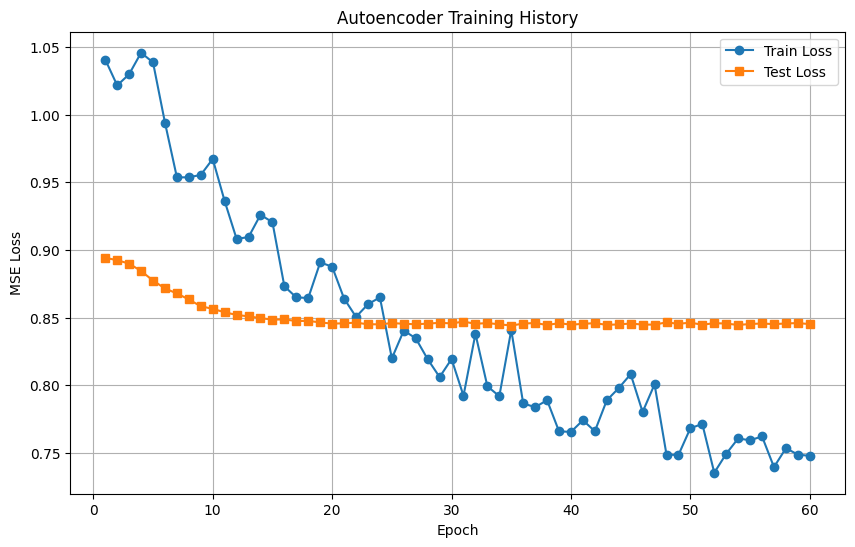


Training Loss (final): 0.747665
Test Loss (final): 0.845116


In [20]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training History')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nTraining Loss (final): {train_losses[-1]:.6f}")
print(f"Test Loss (final): {test_losses[-1]:.6f}")


# Advanced Tasks

• Repeat basic tasks using different activation functions.
• Cluster the encoded data using different models
• Analyze different clusters and compare the difference
• Put the results into the reports


In [21]:
# Flexible Autoencoder class with customizable activation function
class FlexibleAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8, activation='relu'):
        super(FlexibleAutoencoder, self).__init__()
        
        # Select activation function
        if activation == 'relu':
            act_fn = nn.ReLU()
        elif activation == 'tanh':
            act_fn = nn.Tanh()
        elif activation == 'sigmoid':
            act_fn = nn.Sigmoid()
        elif activation == 'leakyrelu':
            act_fn = nn.LeakyReLU(0.2)
        elif activation == 'elu':
            act_fn = nn.ELU()
        else:
            act_fn = nn.ReLU()  # default
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            act_fn,
            nn.Linear(64, 32),
            act_fn,
            nn.Linear(32, latent_dim),
            act_fn
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            act_fn,
            nn.Linear(32, 64),
            act_fn,
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Extract encoded representation"""
        return self.encoder(x)

print("Flexible Autoencoder class defined!")


Flexible Autoencoder class defined!


In [22]:
# Train autoencoders with different activation functions
activation_functions = ['relu', 'tanh', 'sigmoid', 'leakyrelu', 'elu']
models = {}
training_results = {}

num_epochs = 60
criterion = nn.MSELoss()

print("Training autoencoders with different activation functions...")
print("=" * 70)

for act_fn in activation_functions:
    print(f"\nTraining with {act_fn.upper()} activation...")
    print("-" * 70)
    
    # Initialize model
    model = FlexibleAutoencoder(input_dim, latent_dim, activation=act_fn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                reconstructed = model(batch)
                loss = criterion(reconstructed, batch)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 15 == 0:
            print(f"  Epoch [{epoch+1}/{num_epochs}], Train: {train_loss:.6f}, Test: {test_loss:.6f}")
    
    # Store model and results
    models[act_fn] = model
    training_results[act_fn] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1]
    }
    
    print(f"  Final - Train Loss: {train_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}")

print("\n" + "=" * 70)
print("All models trained successfully!")


Training autoencoders with different activation functions...

Training with RELU activation...
----------------------------------------------------------------------
  Epoch [15/60], Train: 0.906382, Test: 0.853704
  Epoch [30/60], Train: 0.831156, Test: 0.845559
  Epoch [45/60], Train: 0.739763, Test: 0.841909
  Epoch [60/60], Train: 0.698666, Test: 0.842373
  Final - Train Loss: 0.698666, Test Loss: 0.842373

Training with TANH activation...
----------------------------------------------------------------------
  Epoch [15/60], Train: 0.959239, Test: 0.860054
  Epoch [30/60], Train: 0.909015, Test: 0.866193
  Epoch [45/60], Train: 0.874865, Test: 0.859701
  Epoch [60/60], Train: 0.828884, Test: 0.857318
  Final - Train Loss: 0.828884, Test Loss: 0.857318

Training with SIGMOID activation...
----------------------------------------------------------------------
  Epoch [15/60], Train: 1.058239, Test: 0.893557
  Epoch [30/60], Train: 1.009798, Test: 0.881010
  Epoch [45/60], Train: 0.9

Comparison of Final Results:
Activation  Train Loss  Test Loss
      relu    0.698666   0.842373
      tanh    0.828884   0.857318
   sigmoid    1.017698   0.883396
 leakyrelu    0.710376   0.847919
       elu    0.602931   0.848102


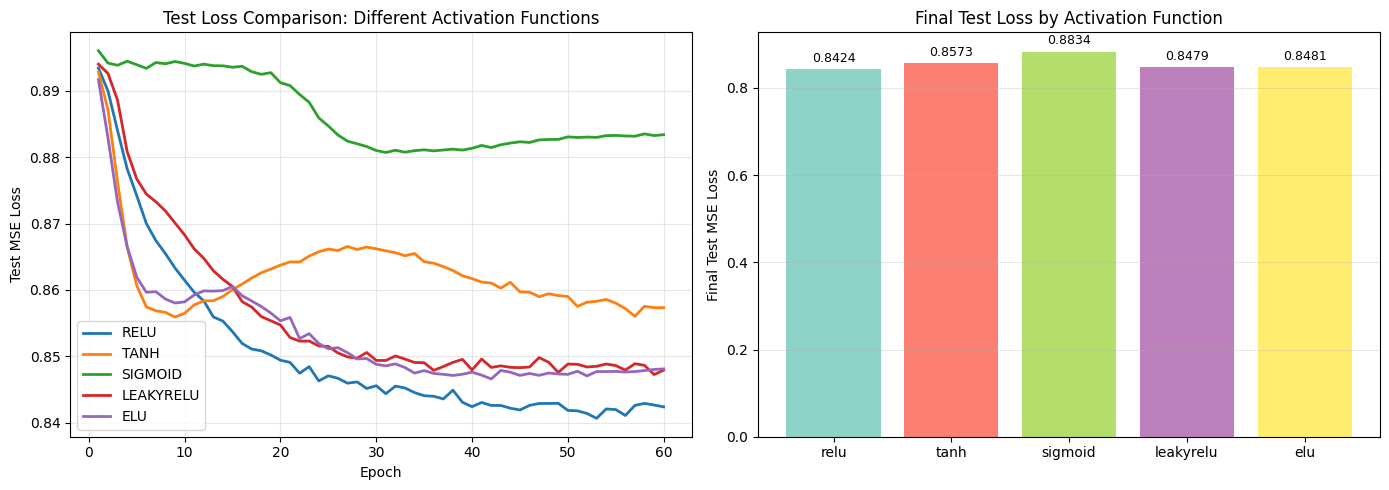


Best activation function (lowest test loss): RELU
Best test loss: 0.842373


In [23]:
# Compare training results across different activation functions
results_df = pd.DataFrame({
    'Activation': activation_functions,
    'Train Loss': [training_results[act]['final_train_loss'] for act in activation_functions],
    'Test Loss': [training_results[act]['final_test_loss'] for act in activation_functions]
})

print("Comparison of Final Results:")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training curves for all activations
ax1 = axes[0]
for act_fn in activation_functions:
    ax1.plot(range(1, num_epochs + 1), training_results[act_fn]['test_losses'], 
             label=f'{act_fn.upper()}', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test MSE Loss')
ax1.set_title('Test Loss Comparison: Different Activation Functions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bar chart of final test losses
ax2 = axes[1]
colors = plt.cm.Set3(np.linspace(0, 1, len(activation_functions)))
bars = ax2.bar(results_df['Activation'], results_df['Test Loss'], color=colors)
ax2.set_ylabel('Final Test MSE Loss')
ax2.set_title('Final Test Loss by Activation Function')
ax2.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, results_df['Test Loss'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Find best activation
best_activation = results_df.loc[results_df['Test Loss'].idxmin(), 'Activation']
print(f"\nBest activation function (lowest test loss): {best_activation.upper()}")
print(f"Best test loss: {results_df['Test Loss'].min():.6f}")


In [24]:
# Extract encoded representations from all trained models
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import seaborn as sns

# Get all data for encoding (not just train/test split)
all_data = torch.FloatTensor(data_scaled.values)
all_loader = DataLoader(TitanicDataset(data_scaled), batch_size=batch_size, shuffle=False)

encoded_data = {}

print("Extracting encoded representations...")
print("-" * 70)

for act_fn in activation_functions:
    model = models[act_fn]
    model.eval()
    
    encoded_list = []
    with torch.no_grad():
        for batch in all_loader:
            encoded = model.encode(batch)
            encoded_list.append(encoded.numpy())
    
    encoded_data[act_fn] = np.vstack(encoded_list)
    print(f"{act_fn.upper()}: Encoded shape {encoded_data[act_fn].shape}")

print("-" * 70)
print("Encoding completed!")


Extracting encoded representations...
----------------------------------------------------------------------
RELU: Encoded shape (891, 8)
TANH: Encoded shape (891, 8)
SIGMOID: Encoded shape (891, 8)
LEAKYRELU: Encoded shape (891, 8)
ELU: Encoded shape (891, 8)
----------------------------------------------------------------------
Encoding completed!


Using encoded data from RELU activation for clustering
Encoded data shape: (891, 8)
----------------------------------------------------------------------

Evaluating optimal number of clusters (K-means)...
  k=2: Inertia=113023.31, Silhouette=0.7598, DB=0.7656
  k=3: Inertia=92481.98, Silhouette=0.7454, DB=1.4568
  k=4: Inertia=82083.61, Silhouette=0.7428, DB=1.4183
  k=5: Inertia=75491.66, Silhouette=0.7114, DB=1.5611
  k=6: Inertia=70573.14, Silhouette=0.7138, DB=1.5640
  k=7: Inertia=67366.05, Silhouette=0.7215, DB=1.5636
  k=8: Inertia=64579.01, Silhouette=0.6495, DB=1.5206
  k=9: Inertia=61222.47, Silhouette=0.6522, DB=1.5448
  k=10: Inertia=57413.64, Silhouette=0.6637, DB=1.4188

Optimal number of clusters: 2 (based on silhouette score)


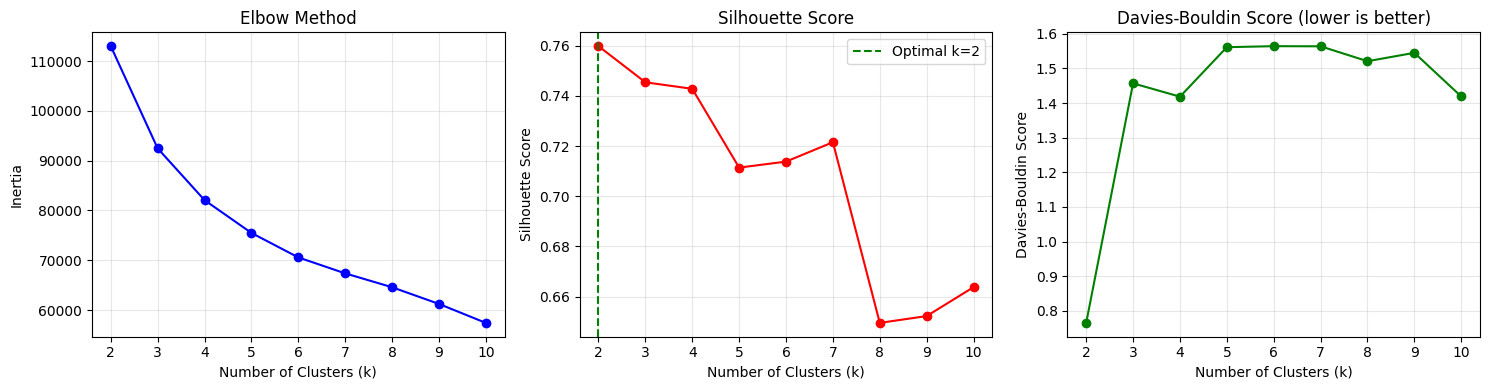

In [25]:
# Apply different clustering algorithms
# We'll use the best activation function's encoded data for clustering
best_encoded = encoded_data[best_activation]
print(f"Using encoded data from {best_activation.upper()} activation for clustering")
print(f"Encoded data shape: {best_encoded.shape}")
print("-" * 70)

# Determine optimal number of clusters using elbow method and silhouette score
from sklearn.metrics import davies_bouldin_score

k_range = range(2, 11)
inertias = []
silhouette_scores = []
db_scores = []

print("\nEvaluating optimal number of clusters (K-means)...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(best_encoded)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(best_encoded, labels)
    silhouette_scores.append(sil_score)
    db_score = davies_bouldin_score(best_encoded, labels)
    db_scores.append(db_score)
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}, DB={db_score:.4f}")

# Find optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k} (based on silhouette score)")

# Plot elbow and silhouette curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].axvline(x=optimal_k, color='g', linestyle='--', label=f'Optimal k={optimal_k}')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(k_range, db_scores, 'go-')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Davies-Bouldin Score (lower is better)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# Apply different clustering algorithms
clustering_results = {}

# 1. K-Means Clustering
print("Applying K-Means clustering...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(best_encoded)
clustering_results['K-Means'] = {
    'labels': kmeans_labels,
    'n_clusters': optimal_k,
    'silhouette': silhouette_score(best_encoded, kmeans_labels),
    'davies_bouldin': davies_bouldin_score(best_encoded, kmeans_labels)
}

# 2. DBSCAN Clustering
print("Applying DBSCAN clustering...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(best_encoded)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
clustering_results['DBSCAN'] = {
    'labels': dbscan_labels,
    'n_clusters': n_clusters_dbscan,
    'n_noise': n_noise,
    'silhouette': silhouette_score(best_encoded, dbscan_labels) if n_clusters_dbscan > 1 else -1,
    'davies_bouldin': davies_bouldin_score(best_encoded, dbscan_labels) if n_clusters_dbscan > 1 else float('inf')
}

# 3. Hierarchical/Agglomerative Clustering
print("Applying Hierarchical clustering...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(best_encoded)
clustering_results['Hierarchical'] = {
    'labels': hierarchical_labels,
    'n_clusters': optimal_k,
    'silhouette': silhouette_score(best_encoded, hierarchical_labels),
    'davies_bouldin': davies_bouldin_score(best_encoded, hierarchical_labels)
}

print("\nClustering completed!")
print("=" * 70)


Applying K-Means clustering...
Applying DBSCAN clustering...
Applying Hierarchical clustering...

Clustering completed!


Clustering Algorithm Comparison:
   Algorithm  Number of Clusters  Silhouette Score  Davies-Bouldin Score  Noise Points
     K-Means                   2          0.759813              0.765559             0
      DBSCAN                  13          0.396576              1.091055           287
Hierarchical                   2          0.754646              0.777742             0


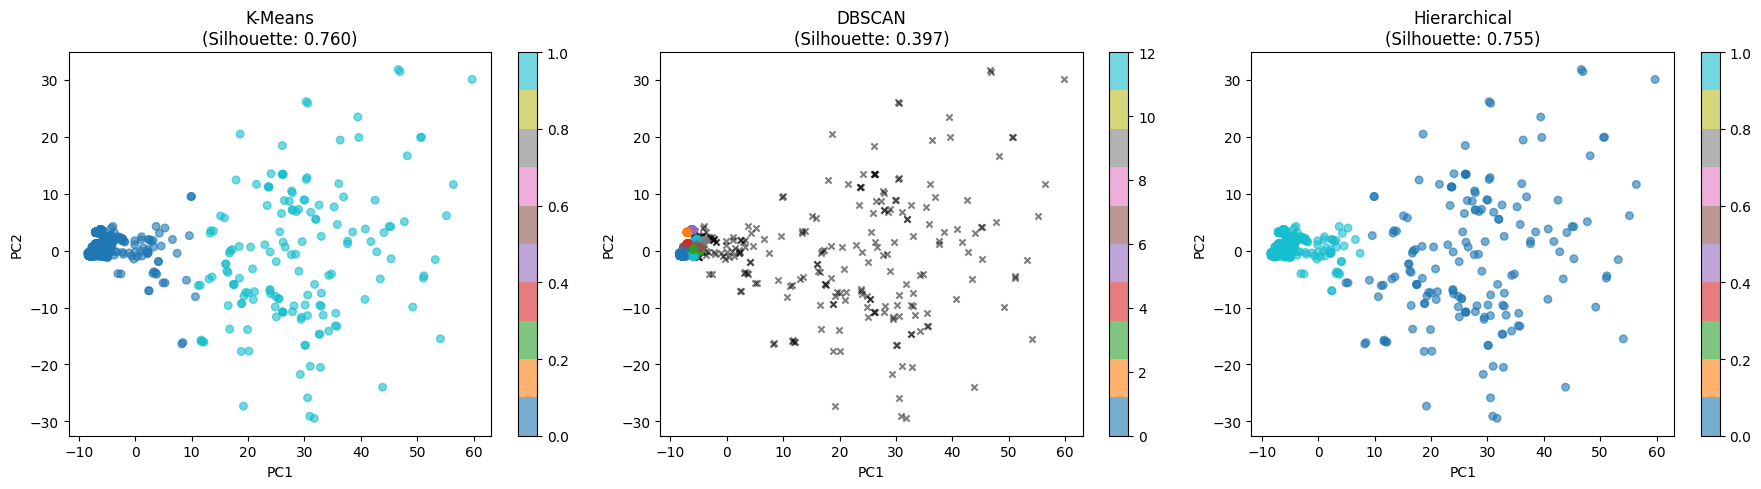


PCA explained variance ratio: [0.6751269  0.09389382]
Total explained variance: 0.7690


In [27]:
# Compare clustering results
clustering_comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Number of Clusters': [
        clustering_results['K-Means']['n_clusters'],
        clustering_results['DBSCAN']['n_clusters'],
        clustering_results['Hierarchical']['n_clusters']
    ],
    'Silhouette Score': [
        clustering_results['K-Means']['silhouette'],
        clustering_results['DBSCAN']['silhouette'],
        clustering_results['Hierarchical']['silhouette']
    ],
    'Davies-Bouldin Score': [
        clustering_results['K-Means']['davies_bouldin'],
        clustering_results['DBSCAN']['davies_bouldin'],
        clustering_results['Hierarchical']['davies_bouldin']
    ]
})

if clustering_results['DBSCAN']['n_noise'] > 0:
    clustering_comparison['Noise Points'] = [0, clustering_results['DBSCAN']['n_noise'], 0]
else:
    clustering_comparison['Noise Points'] = [0, 0, 0]

print("Clustering Algorithm Comparison:")
print("=" * 70)
print(clustering_comparison.to_string(index=False))
print("=" * 70)

# Visualize clustering results using PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
encoded_2d = pca.fit_transform(best_encoded)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(clustering_results.items()):
    labels = result['labels']
    ax = axes[idx]
    
    # Handle noise points in DBSCAN
    if name == 'DBSCAN' and -1 in labels:
        # Plot noise points
        noise_mask = labels == -1
        ax.scatter(encoded_2d[noise_mask, 0], encoded_2d[noise_mask, 1], 
                  c='black', marker='x', s=20, alpha=0.5, label='Noise')
        # Plot clusters
        cluster_mask = ~noise_mask
        scatter = ax.scatter(encoded_2d[cluster_mask, 0], encoded_2d[cluster_mask, 1], 
                           c=labels[cluster_mask], cmap='tab10', s=30, alpha=0.6)
    else:
        scatter = ax.scatter(encoded_2d[:, 0], encoded_2d[:, 1], 
                           c=labels, cmap='tab10', s=30, alpha=0.6)
    
    ax.set_title(f'{name}\n(Silhouette: {result["silhouette"]:.3f})')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")


In [28]:
# Analyze clusters - compare with original features
# Add cluster labels to original data for analysis
df_analysis = df_processed.copy()

# Add cluster labels from each algorithm
for name, result in clustering_results.items():
    df_analysis[f'Cluster_{name}'] = result['labels']

# Analyze each clustering algorithm's clusters
print("=" * 70)
print("CLUSTER ANALYSIS")
print("=" * 70)

for name, result in clustering_results.items():
    print(f"\n{name} Clustering Analysis:")
    print("-" * 70)
    labels = result['labels']
    
    # Skip noise points for DBSCAN in some analyses
    if name == 'DBSCAN' and -1 in labels:
        valid_mask = labels != -1
        cluster_df = df_analysis[valid_mask].copy()
        cluster_labels = labels[valid_mask]
        print(f"  Total points: {len(df_analysis)}")
        print(f"  Valid clusters: {result['n_clusters']}")
        print(f"  Noise points: {result['n_noise']}")
    else:
        cluster_df = df_analysis.copy()
        cluster_labels = labels
        print(f"  Total points: {len(df_analysis)}")
        print(f"  Number of clusters: {result['n_clusters']}")
    
    # Analyze key features by cluster
    print(f"\n  Cluster sizes:")
    unique_labels = sorted(set(cluster_labels))
    for label in unique_labels:
        if label != -1:  # Skip noise label
            count = (cluster_labels == label).sum()
            print(f"    Cluster {label}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")
    
    # Analyze survival rate by cluster
    if 'Survived' in cluster_df.columns:
        print(f"\n  Survival rate by cluster:")
        for label in unique_labels:
            if label != -1:
                cluster_mask = cluster_labels == label
                survival_rate = cluster_df.loc[cluster_mask, 'Survived'].mean()
                print(f"    Cluster {label}: {survival_rate:.3f} ({survival_rate*100:.1f}%)")
    
    # Analyze Pclass distribution by cluster
    if 'Pclass' in cluster_df.columns:
        print(f"\n  Pclass distribution by cluster:")
        for label in unique_labels:
            if label != -1:
                cluster_mask = cluster_labels == label
                pclass_dist = cluster_df.loc[cluster_mask, 'Pclass'].value_counts(normalize=True).sort_index()
                print(f"    Cluster {label}: {dict(pclass_dist)}")
    
    # Analyze Age statistics by cluster
    if 'Age' in cluster_df.columns:
        print(f"\n  Age statistics by cluster:")
        for label in unique_labels:
            if label != -1:
                cluster_mask = cluster_labels == label
                age_stats = cluster_df.loc[cluster_mask, 'Age'].describe()
                print(f"    Cluster {label}: Mean={age_stats['mean']:.1f}, Std={age_stats['std']:.1f}, "
                      f"Min={age_stats['min']:.1f}, Max={age_stats['max']:.1f}")
    
    print()


CLUSTER ANALYSIS

K-Means Clustering Analysis:
----------------------------------------------------------------------
  Total points: 891
  Number of clusters: 2

  Cluster sizes:
    Cluster 0: 734 samples (82.4%)
    Cluster 1: 157 samples (17.6%)

  Survival rate by cluster:
    Cluster 0: 0.322 (32.2%)
    Cluster 1: 0.675 (67.5%)

  Pclass distribution by cluster:
    Cluster 0: {1: np.float64(0.10626702997275204), 2: np.float64(0.23841961852861035), 3: np.float64(0.6553133514986376)}
    Cluster 1: {1: np.float64(0.8789808917197452), 2: np.float64(0.05732484076433121), 3: np.float64(0.06369426751592357)}

  Age statistics by cluster:
    Cluster 0: Mean=28.1, Std=12.1, Min=0.4, Max=74.0
    Cluster 1: Mean=35.3, Std=15.5, Min=0.9, Max=80.0


DBSCAN Clustering Analysis:
----------------------------------------------------------------------
  Total points: 891
  Valid clusters: 13
  Noise points: 287

  Cluster sizes:
    Cluster 0: 233 samples (38.6%)
    Cluster 1: 63 samples (10

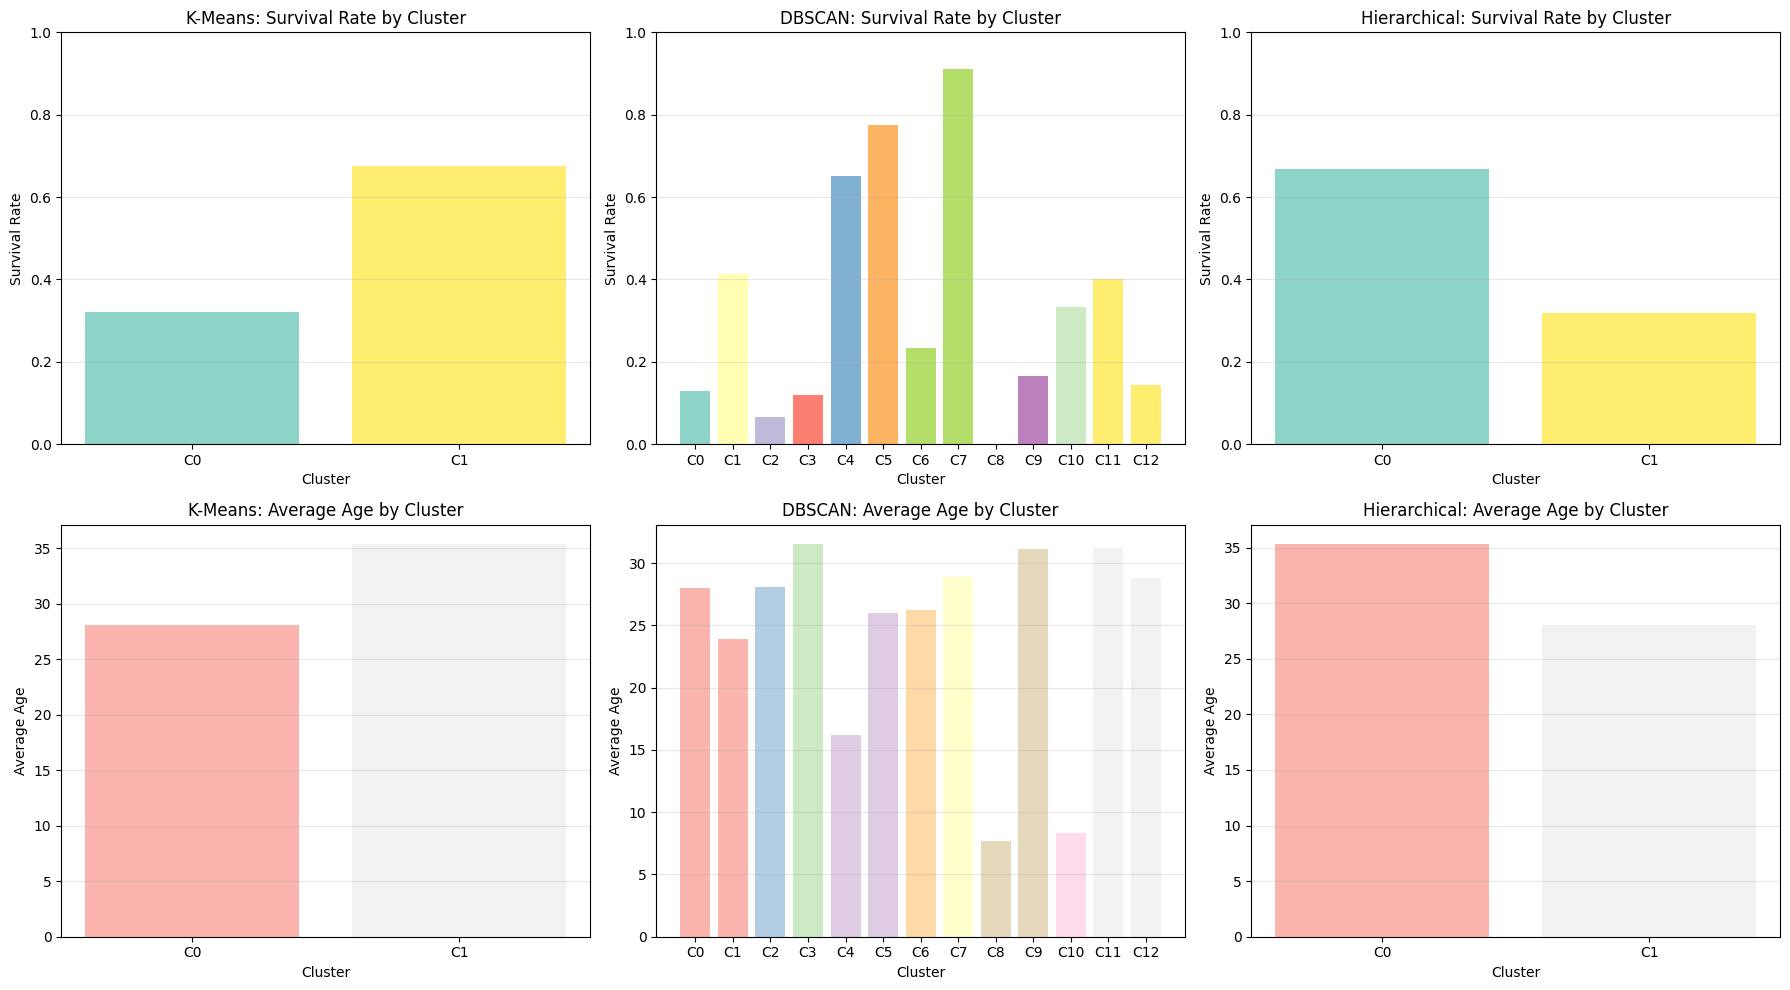

In [29]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# For each clustering algorithm
for idx, (name, result) in enumerate(clustering_results.items()):
    labels = result['labels']
    
    # Filter out noise for DBSCAN in visualizations
    if name == 'DBSCAN' and -1 in labels:
        valid_mask = labels != -1
        plot_labels = labels[valid_mask]
        plot_df = df_analysis[valid_mask]
    else:
        plot_labels = labels
        plot_df = df_analysis
    
    # Plot 1: Survival rate by cluster
    if 'Survived' in plot_df.columns:
        ax = axes[0, idx]
        survival_by_cluster = plot_df.groupby(plot_labels)['Survived'].mean().sort_index()
        bars = ax.bar(range(len(survival_by_cluster)), survival_by_cluster.values, 
                     color=plt.cm.Set3(np.linspace(0, 1, len(survival_by_cluster))))
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Survival Rate')
        ax.set_title(f'{name}: Survival Rate by Cluster')
        ax.set_xticks(range(len(survival_by_cluster)))
        ax.set_xticklabels([f'C{i}' for i in survival_by_cluster.index])
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1])
    
    # Plot 2: Average Age by cluster
    if 'Age' in plot_df.columns:
        ax = axes[1, idx]
        age_by_cluster = plot_df.groupby(plot_labels)['Age'].mean().sort_index()
        bars = ax.bar(range(len(age_by_cluster)), age_by_cluster.values,
                     color=plt.cm.Pastel1(np.linspace(0, 1, len(age_by_cluster))))
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Average Age')
        ax.set_title(f'{name}: Average Age by Cluster')
        ax.set_xticks(range(len(age_by_cluster)))
        ax.set_xticklabels([f'C{i}' for i in age_by_cluster.index])
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [30]:
# Compare cluster assignments between different algorithms
print("=" * 70)
print("CLUSTER COMPARISON BETWEEN ALGORITHMS")
print("=" * 70)

# Compare K-Means vs Hierarchical
kmeans_labels = clustering_results['K-Means']['labels']
hierarchical_labels = clustering_results['Hierarchical']['labels']

# Create contingency table
contingency_table = pd.crosstab(kmeans_labels, hierarchical_labels, margins=True)
print("\nK-Means vs Hierarchical Clustering:")
print(contingency_table)

# Calculate Adjusted Rand Index
ari_km_hr = adjusted_rand_score(kmeans_labels, hierarchical_labels)
print(f"\nAdjusted Rand Index (K-Means vs Hierarchical): {ari_km_hr:.4f}")
print("  (1.0 = perfect agreement, 0.0 = random agreement)")

# Compare with DBSCAN (only valid points)
dbscan_labels = clustering_results['DBSCAN']['labels']
valid_dbscan = dbscan_labels != -1

if valid_dbscan.sum() > 0:
    ari_km_db = adjusted_rand_score(kmeans_labels[valid_dbscan], dbscan_labels[valid_dbscan])
    ari_hr_db = adjusted_rand_score(hierarchical_labels[valid_dbscan], dbscan_labels[valid_dbscan])
    
    print(f"\nAdjusted Rand Index (K-Means vs DBSCAN): {ari_km_db:.4f}")
    print(f"Adjusted Rand Index (Hierarchical vs DBSCAN): {ari_hr_db:.4f}")

print("\n" + "=" * 70)


CLUSTER COMPARISON BETWEEN ALGORITHMS

K-Means vs Hierarchical Clustering:
col_0    0    1  All
row_0               
0        9  725  734
1      157    0  157
All    166  725  891

Adjusted Rand Index (K-Means vs Hierarchical): 0.9521
  (1.0 = perfect agreement, 0.0 = random agreement)

Adjusted Rand Index (K-Means vs DBSCAN): 0.0000
Adjusted Rand Index (Hierarchical vs DBSCAN): 0.0000



# Report Summary

## Results Summary


In [31]:
# Generate comprehensive report
print("=" * 70)
print("COMPREHENSIVE REPORT: AUTOENCODER WITH CLUSTERING ANALYSIS")
print("=" * 70)

print("\n## 1. BASIC TASKS RESULTS")
print("-" * 70)
print(f"Dataset: Titanic (n={len(df_processed)} samples)")
print(f"Input features after preprocessing: {input_dim} dimensions")
print(f"Latent dimension: {latent_dim}")
print(f"Training epochs: {num_epochs}")
print(f"\nOriginal Model (ReLU activation):")
print(f"  - Final Train Loss: {train_losses[-1]:.6f}")
print(f"  - Final Test Loss: {test_losses[-1]:.6f}")

print("\n## 2. ACTIVATION FUNCTION COMPARISON")
print("-" * 70)
print(results_df.to_string(index=False))
print(f"\nBest activation function: {best_activation.upper()}")
print(f"Best test loss: {results_df['Test Loss'].min():.6f}")

print("\n## 3. CLUSTERING RESULTS")
print("-" * 70)
print(f"Clustering performed on encoded data from: {best_activation.upper()} activation")
print(f"Encoded data dimension: {best_encoded.shape[1]}")
print(f"Optimal number of clusters (K-means): {optimal_k}")
print("\nClustering Algorithm Performance:")
print(clustering_comparison.to_string(index=False))

print("\n## 4. KEY FINDINGS")
print("-" * 70)
print("1. Activation Functions:")
print(f"   - {best_activation.upper()} achieved the lowest test loss")
print(f"   - Test loss range: {results_df['Test Loss'].min():.6f} to {results_df['Test Loss'].max():.6f}")

print("\n2. Clustering:")
best_clustering = clustering_comparison.loc[clustering_comparison['Silhouette Score'].idxmax(), 'Algorithm']
print(f"   - Best clustering algorithm (highest silhouette): {best_clustering}")
print(f"   - Silhouette score range: {clustering_comparison['Silhouette Score'].min():.4f} to {clustering_comparison['Silhouette Score'].max():.4f}")

print("\n3. Cluster Characteristics:")
for name, result in clustering_results.items():
    if name == best_clustering:
        labels = result['labels']
        if name == 'DBSCAN' and -1 in labels:
            valid_mask = labels != -1
            cluster_df = df_analysis[valid_mask]
            cluster_labels = labels[valid_mask]
        else:
            cluster_df = df_analysis
            cluster_labels = labels
        
        if 'Survived' in cluster_df.columns:
            print(f"   - {name} clusters show survival rate variation:")
            for label in sorted(set(cluster_labels)):
                if label != -1:
                    survival = cluster_df.loc[cluster_labels == label, 'Survived'].mean()
                    count = (cluster_labels == label).sum()
                    print(f"     Cluster {label}: {survival:.3f} survival rate ({count} samples)")

print("\n" + "=" * 70)
print("Report generation completed!")
print("=" * 70)


COMPREHENSIVE REPORT: AUTOENCODER WITH CLUSTERING ANALYSIS

## 1. BASIC TASKS RESULTS
----------------------------------------------------------------------
Dataset: Titanic (n=891 samples)
Input features after preprocessing: 160 dimensions
Latent dimension: 8
Training epochs: 60

Original Model (ReLU activation):
  - Final Train Loss: 0.602931
  - Final Test Loss: 0.848102

## 2. ACTIVATION FUNCTION COMPARISON
----------------------------------------------------------------------
Activation  Train Loss  Test Loss
      relu    0.698666   0.842373
      tanh    0.828884   0.857318
   sigmoid    1.017698   0.883396
 leakyrelu    0.710376   0.847919
       elu    0.602931   0.848102

Best activation function: RELU
Best test loss: 0.842373

## 3. CLUSTERING RESULTS
----------------------------------------------------------------------
Clustering performed on encoded data from: RELU activation
Encoded data dimension: 8
Optimal number of clusters (K-means): 2

Clustering Algorithm Performan

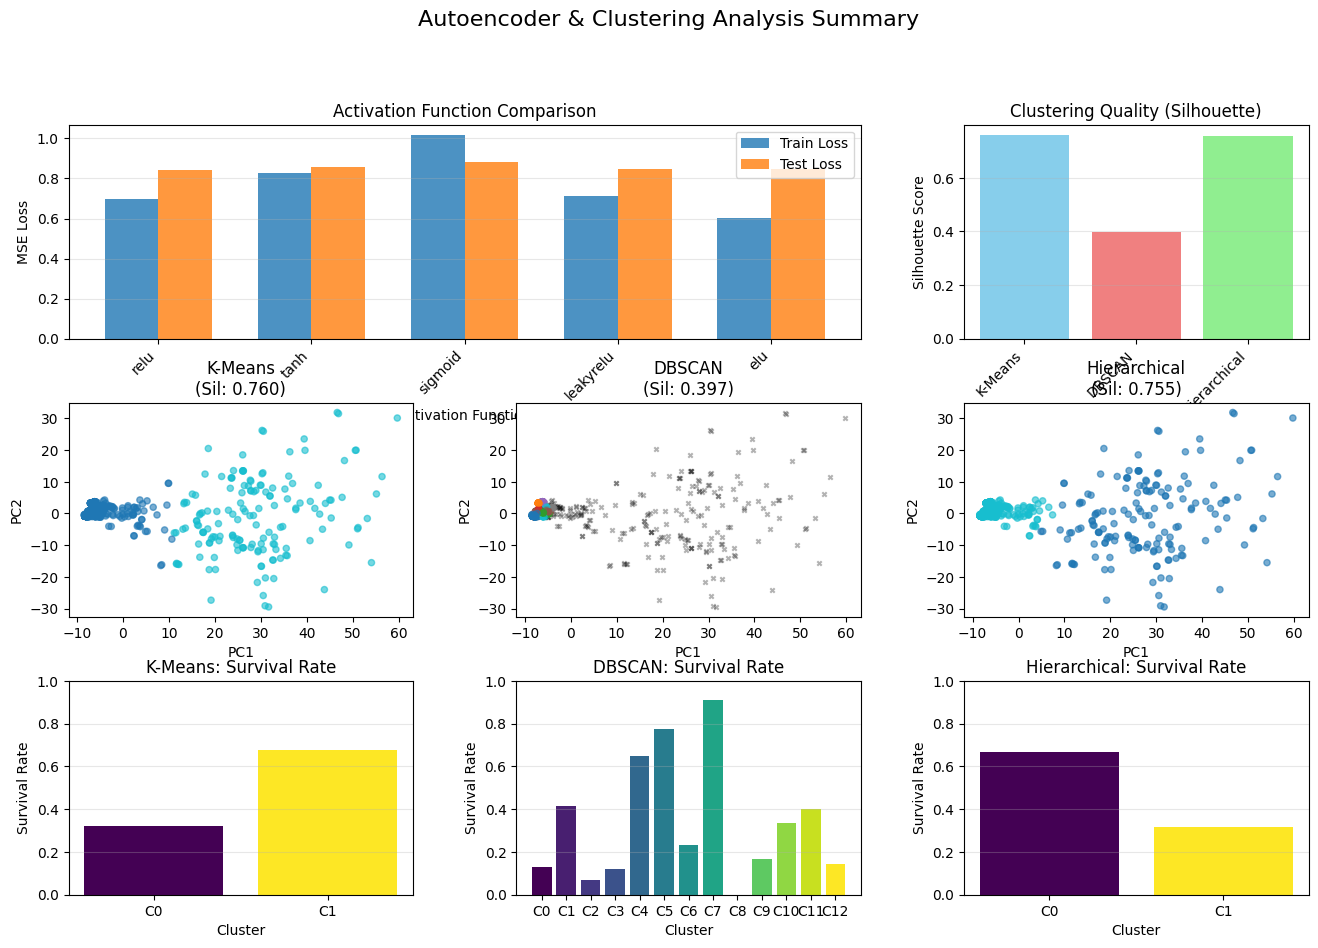

In [32]:
# Create a final summary visualization
fig = plt.figure(figsize=(16, 10))

# Create a grid layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Activation function comparison (top left, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
x_pos = np.arange(len(results_df))
width = 0.35
ax1.bar(x_pos - width/2, results_df['Train Loss'], width, label='Train Loss', alpha=0.8)
ax1.bar(x_pos + width/2, results_df['Test Loss'], width, label='Test Loss', alpha=0.8)
ax1.set_xlabel('Activation Function')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Activation Function Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Activation'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Clustering metrics comparison (top right)
ax2 = fig.add_subplot(gs[0, 2])
x_pos2 = np.arange(len(clustering_comparison))
ax2.bar(x_pos2, clustering_comparison['Silhouette Score'], color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_xlabel('Clustering Algorithm')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Clustering Quality (Silhouette)')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(clustering_comparison['Algorithm'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# 3-5. Cluster visualizations (middle row)
for idx, (name, result) in enumerate(clustering_results.items()):
    ax = fig.add_subplot(gs[1, idx])
    labels = result['labels']
    if name == 'DBSCAN' and -1 in labels:
        noise_mask = labels == -1
        ax.scatter(encoded_2d[noise_mask, 0], encoded_2d[noise_mask, 1], 
                  c='black', marker='x', s=10, alpha=0.3)
        cluster_mask = ~noise_mask
        scatter = ax.scatter(encoded_2d[cluster_mask, 0], encoded_2d[cluster_mask, 1], 
                           c=labels[cluster_mask], cmap='tab10', s=20, alpha=0.6)
    else:
        scatter = ax.scatter(encoded_2d[:, 0], encoded_2d[:, 1], 
                           c=labels, cmap='tab10', s=20, alpha=0.6)
    ax.set_title(f'{name}\n(Sil: {result["silhouette"]:.3f})')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# 6-8. Survival rate by cluster (bottom row)
for idx, (name, result) in enumerate(clustering_results.items()):
    ax = fig.add_subplot(gs[2, idx])
    labels = result['labels']
    if name == 'DBSCAN' and -1 in labels:
        valid_mask = labels != -1
        plot_labels = labels[valid_mask]
        plot_df = df_analysis[valid_mask]
    else:
        plot_labels = labels
        plot_df = df_analysis
    
    if 'Survived' in plot_df.columns:
        survival_by_cluster = plot_df.groupby(plot_labels)['Survived'].mean().sort_index()
        bars = ax.bar(range(len(survival_by_cluster)), survival_by_cluster.values,
                     color=plt.cm.viridis(np.linspace(0, 1, len(survival_by_cluster))))
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Survival Rate')
        ax.set_title(f'{name}: Survival Rate')
        ax.set_xticks(range(len(survival_by_cluster)))
        ax.set_xticklabels([f'C{i}' for i in survival_by_cluster.index])
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1])

plt.suptitle('Autoencoder & Clustering Analysis Summary', fontsize=16, y=0.995)
plt.show()
